In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose  

from sklearn.model_selection import train_test_split
from hana_ml import dataframe as hd

In [68]:
data = conn.sql(""" 
select *
from
    SALES_DATA
""")
sales = data.collect()

In [69]:
sales.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0,219.582
2,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.031
3,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.86,7,0,14.1694
4,11,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.184,9,0.2,85.3092


In [70]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2122 entries, 0 to 2121
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Row ID         2121 non-null   object
 1   Order ID       2121 non-null   object
 2   Order Date     2121 non-null   object
 3   Ship Date      2121 non-null   object
 4   Ship Mode      2121 non-null   object
 5   Customer ID    2121 non-null   object
 6   Customer Name  2121 non-null   object
 7   Segment        2121 non-null   object
 8   Country        2121 non-null   object
 9   City           2121 non-null   object
 10  State          2121 non-null   object
 11  Postal Code    2121 non-null   object
 12  Region         2121 non-null   object
 13  Product ID     2121 non-null   object
 14  Category       2121 non-null   object
 15  Sub-Category   2121 non-null   object
 16  Product Name   2121 non-null   object
 17  Sales          2121 non-null   object
 18  Quantity       2121 non-null

In [71]:
sales['Order Date'] = pd.to_datetime(sales['Order Date'])
sales.set_index('Order Date', inplace=True)

In [72]:
sales['Sales'] = pd.to_numeric(sales['Sales'])

In [73]:
monthly_sales = sales['Sales'].resample('M').sum()

In [74]:
monthly_sales

Order Date
2014-01-31     6242.5250
2014-02-28     1839.6580
2014-03-31    14573.9560
2014-04-30     7944.8370
2014-05-31     6912.7870
2014-06-30    13206.1256
2014-07-31    10821.0510
2014-08-31     7320.3465
2014-09-30    23816.4808
2014-10-31    12304.2470
2014-11-30    21564.8727
2014-12-31    30645.9665
2015-01-31    11739.9416
2015-02-28     3134.3740
2015-03-31    12499.7830
2015-04-30    10475.6985
2015-05-31     9374.9505
2015-06-30     7714.1790
2015-07-31    13674.4200
2015-08-31     9638.5922
2015-09-30    26273.0230
2015-10-31    12026.6235
2015-11-30    30880.8325
2015-12-31    23085.8192
2016-01-31     7622.7430
2016-02-29     3925.5510
2016-03-31    12801.0920
2016-04-30    13212.0900
2016-05-31    15119.8350
2016-06-30    13070.5720
2016-07-31    13068.5190
2016-08-31    12483.2323
2016-09-30    27262.8809
2016-10-31    11872.5770
2016-11-30    31783.6288
2016-12-31    36678.7150
2017-01-31     5964.0320
2017-02-28     6866.3374
2017-03-31    10893.4448
2017-04-30    

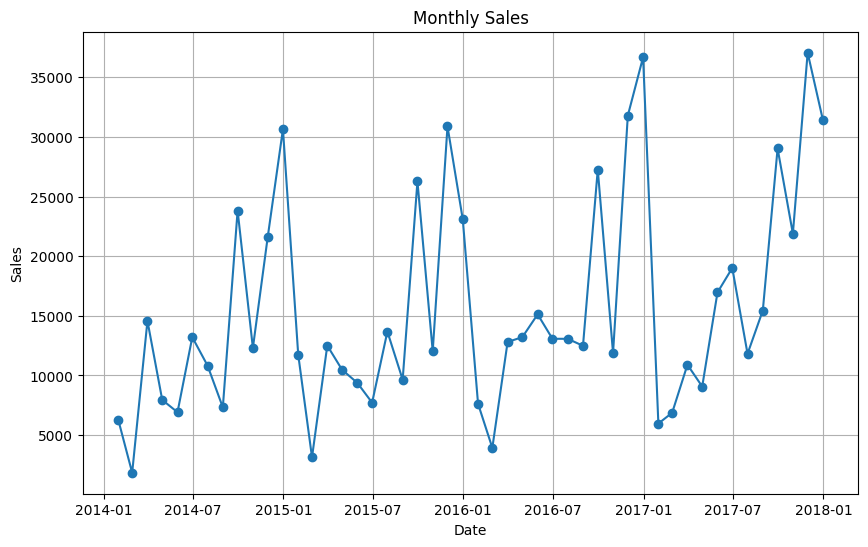

In [75]:
plt.figure(figsize=(10, 6))
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-')
plt.title('Monthly Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

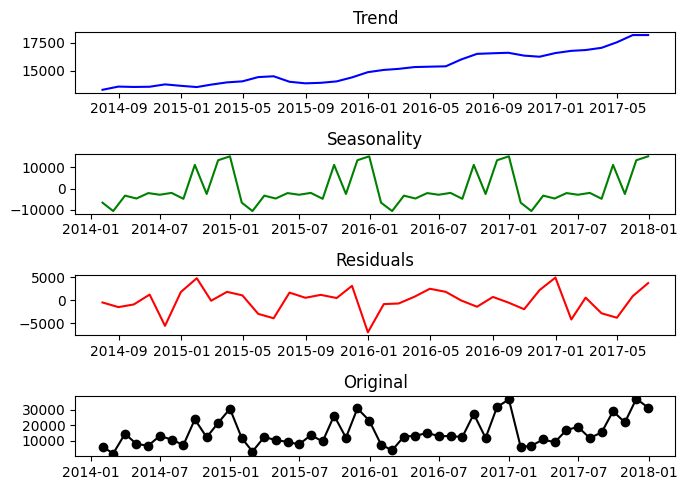

In [76]:
# Seasonal Decomposition Plot
decomposition = seasonal_decompose(monthly_sales, model='additive')
plt.figure(figsize=(7,5))

plt.subplot(4, 1, 1)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.title('Trend')

plt.subplot(4, 1, 2)
plt.plot(decomposition.seasonal, label='Seasonality', color='green')
plt.title('Seasonality')

plt.subplot(4, 1, 3)
plt.plot(decomposition.resid, label='Residuals', color='red')
plt.title('Residuals')

plt.subplot(4, 1, 4)
plt.plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-', label='Original', color='black')
plt.title('Original')

plt.tight_layout()
plt.show()

In [77]:
data = conn.sql(""" 
select TO_INTEGER(ROW_NUMBER() over ()) - 1 as "TIMESTAMP", MONTHLY_SALES from
(select 
	YEAR, MONTH, SUM(SALES) as MONTHLY_SALES
from 
	(select 
		YEAR(TO_DATE("Order Date", 'MM/DD/YYYY')) YEAR, MONTH(TO_DATE("Order Date", 'MM/DD/YYYY')) MONTH, TO_DOUBLE("Sales") SALES 
		from 
			SALES_DATA
		where
		"Sales" is not NULL
	)
where
	YEAR = '2017'
group by YEAR, MONTH
order by YEAR, MONTH)
""")
sales_data_2017_df = data.collect()

In [24]:
sales_data_2017_df.head(5)

,TIMESTAMP,MONTHLY_SALES
0,0,5964.0320
1,1,6866.3374
2,2,10893.4448
3,3,9065.9581
4,4,16957.5582


In [61]:
data = conn.sql(""" 
select *
from
    PAL_ARIMA_SALES_FORECAST_OUT_TBL_<your_xkey>
""")
PALAutoArimaForecast_df = data.collect()

In [62]:
PALAutoArimaForecast_df.head(5)

,TIMESTAMP,FORECAST,SE,LO80,HI80,LO95,HI95
0,0,20867.890586,8316.189031,10210.261900,31525.519271,4568.459468,37167.321704
1,1,16393.810981,8642.738902,5317.691655,27469.930307,-545.646129,33333.268091
2,2,15127.753830,8668.355568,4018.805416,26236.702245,-1861.911021,32117.418682
3,3,14769.490042,8670.403560,3657.917019,25881.063065,-2224.188800,31763.168885
4,4,14668.109989,8670.567533,3556.326826,25779.893151,-2325.890235,31662.110212


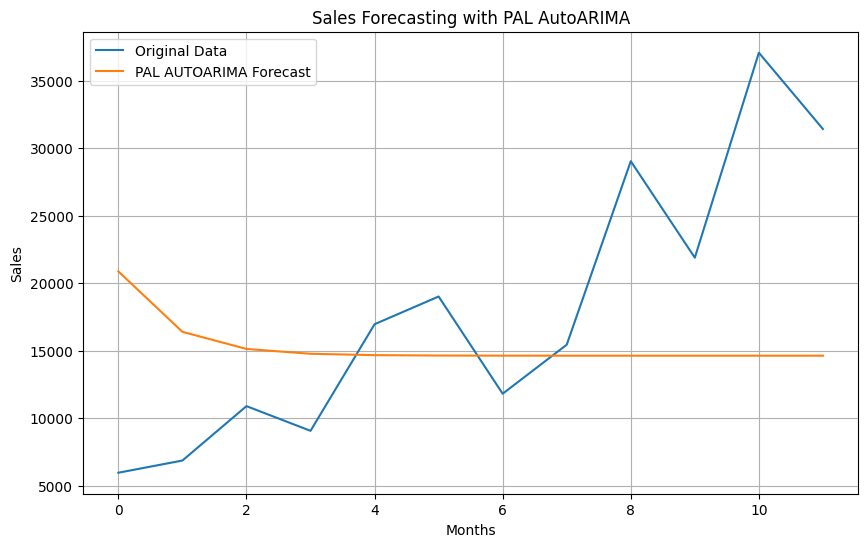

In [79]:
# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(sales_data_2017_df['TIMESTAMP'], sales_data_2017_df['MONTHLY_SALES'], label='Original Data')
plt.plot(PALAutoArimaForecast_df['TIMESTAMP'], PALAutoArimaForecast_df['FORECAST'], label='PAL AUTOARIMA Forecast')
plt.title('Sales Forecasting with PAL AutoARIMA')
plt.xlabel('Months')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()